# Chinook Record Store - SQL Analysis

## Introduction

The Chinook database represents a fictional digital media shop, based on real data from an iTunes Library and manually generated data. The database is provided as a SQLite database file called `chinook.db`.

The `aim` of this project is to explore the [Chinook](https://github.com/lerocha/chinook-database) database using SQL and answer some business questions. 

Here's a schema diagram for the Chinook database:

![Chinook schema diagram](https://s3.amazonaws.com/dq-content/189/chinook-schema.svg)

## Connecting to Chinook Database and Data Overview

The following code to connect our Jupyter Notebook to the database file:

In [496]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

In [497]:
%%sql
--query the database to get a list of all tables and views in our database:
SELECT name, type
  FROM sqlite_master
 WHERE type IN ("table","view");

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


The database consists of 11 tables containing information about artists, albums, media tracks, playlists, invoices, customers, and shop employees.

## Business Analysis

### Selecting new albums to purchase

The Chinook record store has just signed a deal with a new record label, and we've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

| Artist Name          | Genre   |
| -------------------- | ------- |
| Regal                | Hip-Hop |
| Red Tone             | Punk    |
| Meteor and the Girls | Pop     |
| Slim Jim Bites       | Blues   |

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

### `Finding out which genres sell the best in the US`

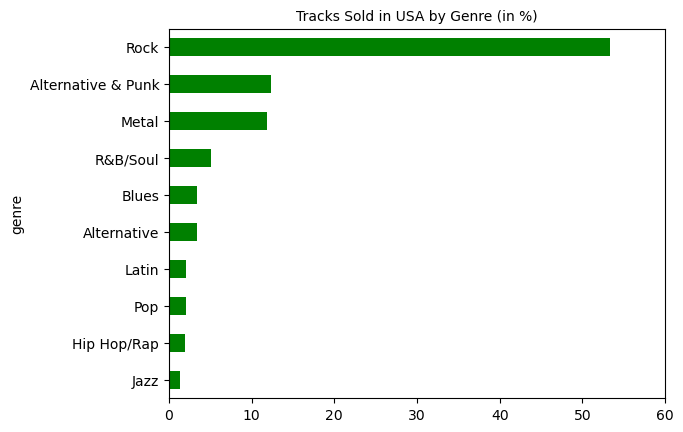

In [540]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

query = """ 
WITH invoice_USA_tbl AS
(
    SELECT il.invoice_line_id, il.track_id
      FROM invoice_line as il
      JOIN invoice as i ON i.invoice_id = il.invoice_id
     WHERE i.billing_country LIKE 'USA'
)   
    SELECT g.name genre,
           COUNT(invUSA.invoice_line_id) num_tracks,
           ROUND((CAST(count(invUSA.invoice_line_id) AS FLOAT) / (SELECT COUNT(*)
                                           FROM invoice_USA_tbl) * 100),2) as pct_sold
      FROM invoice_USA_tbl as invUSA
INNER JOIN track t on t.track_id = invUSA.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
  GROUP BY 1
  ORDER BY 2 DESC
     LIMIT 10;
"""

# Reading SQL results into a pandas DataFrame
conn = sqlite3.connect("chinook.db")
df = pd.read_sql_query(query, conn) 
df
# Resetting the index
df = df.set_index("genre", drop=True) 

# Plotting sold tracks by genre in %
df["pct_sold"].sort_values().plot.barh(color="green",xlim=(0, 60))
plt.title("Tracks Sold in USA by Genre (in %)", fontsize=10)
plt.show()

In [542]:
# Resetting the index
# df = df.set_index("genre", drop=True) 

# Plotting sold tracks by genre in %
# fig, ax = plt.subplots(figsize=(5,8))
# df["pct_sold"].sort_values().plot.barh(color="green",xlim=(0, 60),rot=0)
# ax.set_title("Tracks Sold in USA by Genre (in %)", fontsize=35)
# ax.set_ylabel(None)
# ax.tick_params(axis="both",labelsize=25,left = False)
# ax.spines["top"].set_visible(False)
# ax.spines["right"].set_visible(False)
# ax.spines["left"].set_visible(False)

From the above results, it seems that Rock genre type accounts for more than half of the albums sold in USA, followed by Alternative & Punk and Metal genres with each accounting for around 12%. Altogether these three genres make up around 77% of the albums sold in USA.
But to select the first three albums that will be added to the Chinook store, from a list of four, we can recommend to purchase the new albums by the following artists:

* Red Tone (Punk)
* Slim Jim Bites (Blues)
* Meteor and the Girls (Pop)

However we should keep in mind that we combine the above genres, they make up only 17% of total tracks sold in USA.

## Analyzing Employee Sales Performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. You have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

Let's find the total dollar amount of sales assigned to each sales support agent within the company.

In [500]:
%%sql
WITH sales_rep_invoice_indiv_sales AS
(
    SELECT c.support_rep_id,
           c.customer_id,
           SUM(i.total) as sales
      FROM customer as c
      JOIN invoice as i
        ON c.customer_id = i.customer_id
  GROUP BY c.support_rep_id,c.customer_id
)
    SELECT e.employee_id,e.first_name || " " || e.last_name employee,
           e.title,e.reports_to,
           SUBSTR(e.hire_date,1,10) AS hire_date,
           e.country,
           ROUND(SUM(rep_sales.sales),2) as total_sales
      FROM employee as e
      JOIN sales_rep_invoice_indiv_sales as rep_sales
        ON e.employee_id = rep_sales.support_rep_id
  GROUP BY rep_sales.support_rep_id
  ORDER BY Total_Sales DESC;

 * sqlite:///chinook.db
Done.


employee_id,employee,title,reports_to,hire_date,country,total_sales
3,Jane Peacock,Sales Support Agent,2,2017-04-01,Canada,1731.51
4,Margaret Park,Sales Support Agent,2,2017-05-03,Canada,1584.0
5,Steve Johnson,Sales Support Agent,2,2017-10-17,Canada,1393.92


In [501]:
%%sql
--checking to whom does the employee reports to,
SELECT * 
  FROM employee
 WHERE employee_id = 2;

 * sqlite:///chinook.db
Done.


employee_id,last_name,first_name,title,reports_to,birthdate,hire_date,address,city,state,country,postal_code,phone,fax,email
2,Edwards,Nancy,Sales Manager,1,1958-12-08 00:00:00,2016-05-01 00:00:00,825 8 Ave SW,Calgary,AB,Canada,T2P 2T3,+1 (403) 262-3443,+1 (403) 262-3322,nancy@chinookcorp.com


There are three Sales support agents from Canada (reporting to Sales Manager Nancy Edwards) supporting customers across the world. 
All the agents joined the company in 2017 with Jane Peacock and Margaret Park joining with a one month difference. Going by the total sales figures, there is a correlation between the joining time and the total sales with Jane being the senior compared to the other two agents has more sales than the others. For now, Jane Peacock seems to be the top performer followed by Margaret and Steve.

Let's also look at the `average sales per customer` for each sales agent to analyse their performances.

In [502]:
%%sql
--finding out the total number of customers, the 3 employees service to and also the total number of sales transactions
SELECT COUNT(distinct customer_id) AS num_customers
  FROM customer; --59
SELECT COUNT(DISTINCT invoice_id) AS num_transactions
  FROM invoice; --614

 * sqlite:///chinook.db
Done.
Done.


num_transactions
614


There are 59 unique customers and 614 number of transactions, all serviced by the 3 support agents

In [503]:
%%sql
  SELECT e.first_name || " " || e.last_name AS employee,
         e.country,
         SUBSTR(e.hire_date,1,10) AS hire_Date,
         COUNT(DISTINCT c.customer_id) AS no_of_customers,
         ROUND(CAST(COUNT(DISTINCT c.customer_id) AS FLOAT) / (
                                                                SELECT COUNT(DISTINCT customer_id)
                                                                  FROM customer
                                                              ) * 100,2) AS no_of_customers_pct,
         ROUND(SUM(i.total),2) AS total_sales,
         ROUND(CAST(SUM(i.total) AS FLOAT) / (
                                             SELECT SUM(total)
                                               FROM invoice
                                         ) * 100,0) AS total_sales_pct,
         count(i.invoice_id) AS total_transactions,
         ROUND(SUM(i.total) / CAST(COUNT(DISTINCT c.customer_id) AS FLOAT),2) AS avg_sales_per_customer
    FROM employee e
    JOIN customer c 
      ON e.employee_id = c.support_rep_id
    JOIN invoice i 
      ON c.customer_id = i.customer_id                               
GROUP BY c.support_rep_id
ORDER BY avg_sales_per_Customer DESC;

 * sqlite:///chinook.db
Done.


employee,country,hire_Date,no_of_customers,no_of_customers_pct,total_sales,total_sales_pct,total_transactions,avg_sales_per_customer
Jane Peacock,Canada,2017-04-01,21,35.59,1731.51,37.0,212,82.45
Margaret Park,Canada,2017-05-03,20,33.9,1584.0,34.0,214,79.2
Steve Johnson,Canada,2017-10-17,18,30.51,1393.92,30.0,188,77.44


From the above results, looking at the percentage of the number of customers attended by the agents, Jane Peacock has more customers compared to others. Also, by the average sales per customers figures, again Jane Peacock leads the show compared to Margaret and Steve. However, Steve Johnson, even though joined 6 months later than Jane has fared better in performance.

## Analyzing Sales by Country

Our next task is to analyze the sales data for customers from each different country. In particular, we have to calculate data, for each country, on the:

1. total number of customers
2. total value of sales
3. average value of sales per customer
4. average order value

Because there are a number of countries with only one customer, we are going to group these customers as "Other" in our analysis. 

In [504]:
%%sql
WITH all_countries_tbl AS
(     
      SELECT 
                CASE
                WHEN COUNT(DISTINCT c.customer_id) <= 1 THEN 'Others'
                ELSE c.country
                END AS country,
                COUNT(DISTINCT c.customer_id) AS no_of_customers, SUM(i.total) AS total_sales, 
                COUNT(DISTINCT i.invoice_id) AS no_of_invoices
        FROM customer AS c
        JOIN invoice AS i
          ON c.customer_id = i.customer_id
    GROUP BY c.country
    ORDER BY no_of_customers DESC
)
SELECT      country,
            SUM(no_of_customers) AS no_of_customers,
            ROUND(SUM(total_sales),2) AS total_sales,
            ROUND(SUM(total_sales) / SUM(no_of_customers),2) AS avg_sales_per_customer,
            SUM(no_of_invoices) AS num_of_invoices,
            ROUND(SUM(total_sales) / SUM(no_of_invoices),2) AS average_order 
       FROM all_countries_tbl
   GROUP BY country
   ORDER BY CASE
            WHEN country LIKE 'Others' THEN 1
            ELSE 0
            END ASC, 
            total_sales DESC;

 * sqlite:///chinook.db
Done.


country,no_of_customers,total_sales,avg_sales_per_customer,num_of_invoices,average_order
USA,13,1040.49,80.04,131,7.94
Canada,8,535.59,66.95,76,7.05
Brazil,5,427.68,85.54,61,7.01
France,5,389.07,77.81,50,7.78
Germany,4,334.62,83.66,41,8.16
Czech Republic,2,273.24,136.62,30,9.11
United Kingdom,3,245.52,81.84,28,8.77
Portugal,2,185.13,92.57,29,6.38
India,2,183.15,91.58,21,8.72
Others,15,1094.94,73.0,147,7.45


From the above results, USA dominates the sales in terms of both the total sales and the number of customers. We can also notice a strong positive correlation between the number of customers and the total sales.
By looking at the average sales per customer, Czech Republic, India, Portugal and United Kingdom provides more value per customer even though the number of customers is less. The company can focus their marketing strategy in these countries. However, the amount of data from each of these countries is relatively low. As such, we should be cautious about spending too much money on new marketing campaigns because the sample size isn't large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.

## Analysis for changing Purchasing Strategy

### Albums vs Individual Tracks

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

- purchase a whole album
- purchase a collection of one or more individual tracks

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.
We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

We're going to identify whether each invoice has all the tracks from an album. We can do this by getting the list of tracks from an invoice and comparing it to the list of tracks from an album. We can find the album to compare the purchase to by looking up the album that one of the purchased tracks belongs to. It doesn't matter which track we pick, since if it's an album purchase, that album will be the same for all tracks.

The following query categorizes each invoice as either an album purchase or not, and calculates the following summary statistics:

`Number of invoices`
`Percentage of invoices`

In [505]:
%%sql
WITH invoices_all_tracks AS
(
    SELECT i.invoice_id, il.track_id
      FROM invoice AS i
      JOIN invoice_line AS il
        ON i.invoice_id = il.invoice_id
),
invoices_first_track AS 
(
    SELECT invoice_id, MIN(track_id) AS first_track_id
      FROM invoices_all_tracks
  GROUP BY invoice_id
),
invoices_albums AS
(
    SELECT inv.*,
           CASE
           WHEN
                (
                  SELECT ial.track_id 
                    FROM invoices_all_tracks AS ial 
                   WHERE ial.invoice_id = inv.invoice_id
                  EXCEPT
                  SELECT track_id 
                    FROM track 
                   WHERE album_id =
                      (
                        SELECT album_id 
                          FROM track 
                         WHERE track_id = inv.first_track_id
                      )
                ) IS NULL
                AND 
                (
                  SELECT track_id 
                    FROM track 
                   WHERE album_id =
                    (
                        SELECT album_id 
                          FROM track 
                         WHERE track_id = inv.first_track_id
                    )
                 EXCEPT
                 SELECT ial.track_id 
                   FROM invoices_all_tracks AS ial 
                  WHERE ial.invoice_id = inv.invoice_id
               ) IS NULL THEN 'YES'
           ELSE 'NO'
           END AS album_purchase
    FROM invoices_first_track AS inv
)
  SELECT
          album_purchase,
          COUNT(invoice_id) AS number_of_invoices,
          ROUND(CAST(COUNT(invoice_id) AS FLOAT) / 
                        (SELECT COUNT(*) FROM invoice),2) * 100 AS percent_of_invoices
    FROM invoices_albums 
GROUP BY album_purchase;

 * sqlite:///chinook.db
Done.


album_purchase,number_of_invoices,percent_of_invoices
NO,500,81.0
YES,114,19.0


From the above results, 81% of the purchases are bought as individual tracks and only 19% as albums. Therefore the strategy they are considering to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album is definitely recommended.

## Other Business Questions:

###  1. Most Popular Artist

Popularity of an artist could be defined as one who has been in most number of playlists, in terms of track sales, the number of fans or other factors. Spotify calculates artists' popularity by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. We will calculate the popularity by finding out the artist who appears in most number of playlists and also in terms of sales.

a. Popular Artist in `most number of playlists`

In [506]:
%%sql
  SELECT ar.name AS artist_name, 
         COUNT(t.track_id) AS num_tracks,
         COUNT(DISTINCT(pt.playlist_id)) AS num_playlists
    FROM artist AS ar
    JOIN album AS al 
      ON al.artist_id = ar.artist_id
    JOIN track AS t
      ON t.album_id = al.album_id
    JOIN playlist_track AS pt
      ON t.track_id = pt.track_id
GROUP BY ar.name
ORDER BY num_playlists DESC 
   LIMIT 10;

 * sqlite:///chinook.db
Done.


artist_name,num_tracks,num_playlists
Eugene Ormandy,15,7
The King's Singers,10,6
English Concert & Trevor Pinnock,9,6
Berliner Philharmoniker & Herbert Von Karajan,13,6
Academy of St. Martin in the Fields & Sir Neville Marriner,10,6
Yo-Yo Ma,5,5
Wilhelm Kempff,5,5
Ton Koopman,5,5
"Sir Georg Solti, Sumi Jo & Wiener Philharmoniker",5,5
Sir Georg Solti & Wiener Philharmoniker,5,5


Eugene Ormandy has 15 tracks and appeared in 7 playlists and is the most popular artist.

b. Most popular Artist in terms of `tracks sales`

In [507]:
%%sql
WITH most_track_sold AS
(
  SELECT il.track_id, 
         ROUND(SUM(il.unit_price * il.quantity),2) AS total,
         t.album_id
    FROM invoice_line AS il
    JOIN track AS t
      ON il.track_id = t.track_id
GROUP BY il.track_id
ORDER BY total DESC
   LIMIT 10
)
  SELECT ar.name AS artist_name, 
         t.total AS sales
    FROM most_track_sold AS t
    JOIN album AS al
      ON t.album_id = al.album_id
    JOIN artist AS ar
      ON al.artist_id = ar.artist_id
GROUP BY ar.name
ORDER BY sales DESC;

 * sqlite:///chinook.db
Done.


artist_name,sales
Cake,30.69
Jimi Hendrix,13.86
AC/DC,12.87
System Of A Down,11.88
Godsmack,10.89


Cake seems to the most popular in terms of sales of his songs.

### 2. Purchased vs Not Purchased Tracks

In [508]:
%%sql
WITH tracks_all_purchased_tbl AS
(
SELECT COUNT(DISTINCT t.track_id) AS num_tracks, COUNT(DISTINCT il.track_id) AS purchased_tracks
    FROM track AS t
    LEFT JOIN invoice_line AS il
    ON t.track_id = il.track_id
)
SELECT num_tracks,
        purchased_tracks AS sold_tracks,
    ROUND(CAST(purchased_tracks AS FLOAT) /num_tracks ,2) AS pct_sold,
    (num_tracks - purchased_tracks) AS unsold_tracks
FROM tracks_all_purchased_tbl;

 * sqlite:///chinook.db
Done.


num_tracks,sold_tracks,pct_sold,unsold_tracks
3503,1806,0.52,1697


Out of 3503 tracks, 52% of the tracks are purchased and almost half of the total number of tracks are unsold. Marketing is needed to promote the tracks to the customers and also it is suggested to understand why these tracks are unpopular among the buyers.

### 3. Effect of Protected & Non-protected media types on Popularity

A protected media file is any media file that has associated rules for using the content. Let's start by looking at the unique values of media types and whether there are any protected types among them.

In [509]:
%%sql
SELECT DISTINCT(name) AS media_type
  FROM media_type;

 * sqlite:///chinook.db
Done.


media_type
MPEG audio file
Protected AAC audio file
Protected MPEG-4 video file
Purchased AAC audio file
AAC audio file


Two of the five media types are protected.

In [510]:
%%sql
WITH media_with_tracks_sold AS 
(
   SELECT m.name AS media_name,
          COUNT(DISTINCT t.track_id) AS available_unique_tracks,
          COUNT(DISTINCT il.track_id) AS num_unique_tracks_sold,
          SUM(il.quantity) AS num_tracks_sold_per_media,
          CASE
          WHEN m.name LIKE 'Protected%' THEN 'Protected'
          ELSE 'Unprotected'
          END AS media_type
     FROM track AS t
LEFT JOIN invoice_line AS il ON il.track_id = t.track_id
     JOIN media_type AS m ON t.media_type_id = m.media_type_id
 GROUP BY m.name
)
  SELECT media_type,
         SUM(num_tracks_sold_per_media) AS tracks_sold,
         ROUND((SUM(num_tracks_sold_per_media) * 1.0 / (
                                                            SELECT SUM(num_tracks_sold_per_media) 
                                                              FROM media_with_tracks_sold
                                                       )) * 100,4) AS '%_tracks_sold',
         SUM(available_unique_tracks) AS available_unique_tracks,
         SUM(num_unique_tracks_sold) AS unique_tracks_sold,
         ROUND((SUM(num_unique_tracks_sold) * 1.0) / SUM(available_unique_tracks) * 100,4) AS '%_of_sold_unique_tracks'
    FROM media_with_tracks_sold
GROUP BY media_type; 

 * sqlite:///chinook.db
Done.


media_type,tracks_sold,%_tracks_sold,available_unique_tracks,unique_tracks_sold,%_of_sold_unique_tracks
Protected,442,9.2916,451,154,34.1463
Unprotected,4315,90.7084,3052,1652,54.1284


From this table, we can make the following observations:

In terms of sales, 90% of the tracks sold are of unprotected media types and only around 10% are protected types. In terms of assortment, only 13% (451/3503) of all the unique tracks available in the Chinook store are of protected media types.
From all the unique tracks of protected media types, only 34% were sold, while from those of non-protected ones - 54%.
Among all the tracks that were sold, those of protected media types amounts only to 9%.
In a nutshell, the tracks of protected media types are much less popular than those of non-protected, both in terms of the store assortment and, especially, in terms of sales.

### 4. Range of tracks and their Sales Popularity

In [511]:
%%sql
WITH genre_summary AS
(
SELECT g.name AS Genre,
       COUNT(DISTINCT t.track_id) AS num_of_tracks,
       COUNT(il.track_id) AS num_of_tracks_sold,
       ROUND(SUM(il.unit_price * il.quantity),2) AS total_sales
FROM track AS t
JOIN genre AS g ON t.genre_id = g.genre_id
LEFT JOIN invoice_line AS il ON t.track_id = il.track_id
GROUP BY g.name
--HAVING COUNT(il.track_id) > 0
)
SELECT Genre,num_of_tracks,
       ROUND(((num_of_tracks * 1.0) / (SELECT SUM(num_of_tracks) FROM genre_summary)) * 100,3) AS relative_num_tracks,
       num_of_tracks_sold,
       total_sales,
       ROUND(((total_sales * 1.0) / (SELECT SUM(total_sales) FROM genre_summary)) * 100,3) AS revenue_share
FROM genre_summary
--ORDER BY revenue_share DESC;
ORDER BY relative_num_tracks DESC,revenue_share DESC;

 * sqlite:///chinook.db
Done.


Genre,num_of_tracks,relative_num_tracks,num_of_tracks_sold,total_sales,revenue_share
Rock,1297,37.025,2635,2608.65,55.392
Latin,579,16.529,167,165.33,3.511
Metal,374,10.677,619,612.81,13.012
Alternative & Punk,332,9.478,492,487.08,10.343
Jazz,130,3.711,121,119.79,2.544
TV Shows,93,2.655,2,1.98,0.042
Blues,81,2.312,124,122.76,2.607
Classical,74,2.112,47,46.53,0.988
Drama,64,1.827,1,0.99,0.021
R&B/Soul,61,1.741,159,157.41,3.342


37% of the tracks in the store are of Rock genre and 55% of sales revenue comes from this genre. This purchasing strategy seems to be reflective of popularity. Also for Metal genre (around 11% are available yielding 13% revenue share). However 16% of tracks in the store are of Latin genre which yields only 3% of sales revenue. Let's use the Pearson Correlation Coefficient and find out the correlation between the range of tracks and sales.

In [512]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

query = """ 
WITH genre_summary AS
(
SELECT g.name AS Genre,
       COUNT(DISTINCT t.track_id) AS num_of_tracks,
       COUNT(il.track_id) AS num_of_tracks_sold,
       ROUND(SUM(il.unit_price * il.quantity),2) AS total_sales
FROM track AS t
JOIN genre AS g ON t.genre_id = g.genre_id
LEFT JOIN invoice_line AS il ON t.track_id = il.track_id
GROUP BY g.name
--HAVING COUNT(il.track_id) > 0
)
SELECT Genre,num_of_tracks,
       ROUND(((num_of_tracks * 1.0) / (SELECT SUM(num_of_tracks) FROM genre_summary)) * 100,3) AS relative_num_tracks,
       num_of_tracks_sold,
       total_sales,
       ROUND(((total_sales * 1.0) / (SELECT SUM(total_sales) FROM genre_summary)) * 100,3) AS revenue_share
FROM genre_summary
--ORDER BY revenue_share DESC;
ORDER BY relative_num_tracks DESC,revenue_share DESC;
"""

# Reading SQL results into a pandas DataFrame
conn = sqlite3.connect("chinook.db")
df = pd.read_sql_query(query, conn) 
df

,Genre,num_of_tracks,relative_num_tracks,num_of_tracks_sold,total_sales,revenue_share
0,Rock,1297,37.025,2635,2608.65,55.392
1,Latin,579,16.529,167,165.33,3.511
2,Metal,374,10.677,619,612.81,13.012
3,Alternative & Punk,332,9.478,492,487.08,10.343
4,Jazz,130,3.711,121,119.79,2.544
5,TV Shows,93,2.655,2,1.98,0.042
6,Blues,81,2.312,124,122.76,2.607
7,Classical,74,2.112,47,46.53,0.988
8,Drama,64,1.827,1,0.99,0.021
9,R&B/Soul,61,1.741,159,157.41,3.342


In [513]:
df.corr(numeric_only=True)

,num_of_tracks,relative_num_tracks,num_of_tracks_sold,total_sales,revenue_share
num_of_tracks,1.000000,1.000000,0.934280,0.931614,0.931616
relative_num_tracks,1.000000,1.000000,0.934275,0.931609,0.931611
num_of_tracks_sold,0.934280,0.934275,1.000000,1.000000,1.000000
total_sales,0.931614,0.931609,1.000000,1.000000,1.000000
revenue_share,0.931616,0.931611,1.000000,1.000000,1.000000


In [514]:
df['relative_num_tracks'].corr(df['revenue_share'])

0.9316107723268707

There is a positive correlation and this suggests that the range of tracks is reflective of popularity in terms of sales.

## Conclusion

In this project, we have analyzed the Chinook database using SQLite to extract the following insights to help solve some business questions:

- `Rock` genre type accounts for more than half of the albums sold in USA, followed by Alternative & Punk and Metal genres with each accounting for around 12%. Altogether these three genres make up around 77% of the albums sold in USA. From the 4 albums in consideration to select from the new record label based in USA, the following 3 albums are recommended for purchasing and advertising in the USA, based on the genre popularity in USA:

| Artist Name          | Genre   |
| -------------------- | ------- |
| Red Tone             | Punk    |
| Slim Jim Bites       | Blues   |
| Meteor and the Girls | Pop     |

  However we should keep in mind that we combine the above genres, they make up only 17% of total tracks sold in USA.

- Of the 3 sales support agents, Jane Peacock demonstrates the most effective sales performance followed by Margaret Park and Steve Johnson. All the agents joined the company in 2017 with Jane Peacock and Margaret Park joining with a one month difference. Going by the total sales figures, there is a correlation between the joining time and the total sales with Jane being the senior compared to the other two agents has more sales than the others. For now, Jane Peacock seems to be the top performer followed by Margaret and Steve. Further,looking at the percentage of the number of customers attended by the agents, Jane Peacock has more customers compared to others. Also, by the average sales per customers figures, again Jane Peacock leads the show compared to Margaret and Steve. However, Steve Johnson, even though joined 6 months later than Jane has fared better in performance.

- Of all the countries, USA dominates the sales in terms of both the total sales and the number of customers. By looking at the average sales per customer, Czech Republic, India, Portugal and United Kingdom provides more value per customer even though the number of customers is less. The company can focus their marketing strategy in these countries. However, the amount of data from each of these countries is relatively low. As such, we should be cautious about spending too much money on new marketing campaigns because the sample size isn't large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.

- Customers tend to buy individual tracks much more often than the whole albums. 81% of the purchases are bought as individual tracks and only 19% as albums. Therefore the strategy they are considering to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album is definitely recommended.

- Eugene Ormandy has 15 tracks and appeared in 7 playlists and is the most popular artist. But by sales, Cake seems to the most popular artist.

- Out of 3503 tracks, 52% of the tracks are purchased and almost half of the total number of tracks are unsold. Marketing is needed to promote the tracks to the customers and also it is suggested to understand why these tracks are unpopular among the buyers.

- In terms of sales, 90% of the tracks sold are of unprotected media types and only around 10% are protected types. In terms of assortment, only 13% of all the unique tracks available in the Chinook store are of protected media types. From all the unique tracks of protected media types, only 34% were sold, while from those of non-protected ones - 54%. Among all the tracks that were sold, those of protected media types amounts only to 9%. In a nutshell, the tracks of protected media types are much less popular than those of non-protected, both in terms of the store assortment and, especially, in terms of sales.

- 37% of the tracks in the store are of Rock genre and 55% of sales revenue comes from this genre. This purchasing strategy seems to be reflective of popularity. Also for Metal genre (around 11% are available yielding 13% revenue share). However 16% of tracks in the store are of Latin genre which yields only 3% of sales revenue. Let's use the Pearson Correlation Coefficient and find out the correlation between the range of tracks and sales.